# Assignment 3 | Stroke Prediction

![Stroke](https://i.makeagif.com/media/11-12-2015/kxoOxr.gif)

## Problem Statement

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Source: [Kaggle - Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

## Import Libraries and Load the Dataset

In [97]:
#import libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

!pip install pywaffle
from pywaffle import Waffle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score ,precision_score, f1_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
#Read In Dataset
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv', index_col='id')
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

## Exploratory Data Analysis (EDA)

Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
> "Unknown" in smoking_status means that the information is unavailable for this patient

In [99]:
#displays stats about the numerical features
df.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [100]:
#displays stats about the catagorical features
df.describe(exclude = ['float', 'int64'])

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

In [101]:
#displays amount of null values for each column
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


<h5>BMI is the only column that has missing values. This will be handled later with KNN Imputer.</h5>

In [102]:
#display percent of dataset with stroke
perc_dis = df['stroke'].sum() / len(df)
print('Percent of patients in dataset with stroke:', round(perc_dis, 4))

Percent of patients in dataset with stroke: 0.0487


<h5>Only about 5% of the patients in the dataset experienced a stroke. While this may be good news for the patients, it makes creating our model more difficult. Later I will need to use SMOTE to balance the dataset.</h5>

In [103]:
sns.set(style="ticks");
pal = ["#FA5858", "#58D3F7"]

sns.pairplot(df, hue="stroke", palette=pal);
plt.title("stroke");

### Strokes by Age

In [104]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#00f5d4','#f15bb5']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 6:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#-------Ax 1------------------------------------------------
sns.kdeplot('age', data=df, ax=ax1, shade=True, color='#9b5de5', alpha=1)
ax1.set_xlabel('Age', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax1.text(-20, 0.035, 'Overall Age Distribution', fontfamily='serif', fontsize=25,color= 'black',fontweight='bold')
ax1.text(-20, 0.0275, 'The dataset contains a fairly balanced distribution \nof samples respective to age.',
         fontfamily='serif', color= 'black', fontsize=14)
ax1.text(50, 0.019, 'Total',fontfamily='serif', fontsize=16,color= '#9b5de5',fontweight='bold')
ax1.text(68, 0.019, '=',fontfamily='serif', fontsize=16,color= 'black',fontweight='bold')
ax1.text(75, 0.019, 'Stroke',fontfamily='serif', fontsize=16,color= '#f15bb5',fontweight='bold')
ax1.text(98.5, 0.019, '+',fontfamily='serif', fontsize=16,color= 'black',fontweight='bold')
ax1.text(105, 0.019, 'Healthy',fontfamily='serif', fontsize=16,color= '#00c5a4',fontweight='bold')

#-------Ax 2------------------------------------------------
sns.kdeplot('age', data=df[df.stroke==0], ax=ax2, shade=True, 
            color='#00f5d4', alpha=1)
sns.kdeplot('age', data=df[df.stroke==1], ax=ax2, shade=True, 
            color='#f15bb5', alpha=0.8)
ax2.set_xlabel('Age', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax2.text(-20, 0.06, 'Age Distribution by Stroke', fontfamily='serif', fontsize=25,color= 'black',fontweight='bold')
ax2.text(-20, 0.05, 'There is a clear relationship present between age and\nstroke: as age increase so does ' +\
                         'risk of stroke.',
         fontfamily='serif', color= 'black', fontsize=14)
ax2.text(50, 0.042,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax2.text(75, 0.042,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax2.text(80, 0.042,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')

#-------Ax 3------------------------------------------------
ax3.get_yaxis().set_visible(True)
sns.violinplot(x='age', y='gender', data=df[df.gender!='Other'],
               hue='stroke', ax=ax3, aspect=2, inner=None)
ax3.set_yticklabels( labels = ['Male', 'Female'],
                fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.set_ylabel('')
ax3.set_xlabel('Age', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.get_legend().remove()
ax3.text(-40, -0.975, 'Sex, Age, and Stroke', fontfamily='serif', fontsize=25,color= 'black',fontweight='bold')
ax3.text(-40, -0.7, 'Both males and females have a greater risk of stroke as\nthey age. However, ' +\
         'females are prone to suffer strokes\nfrom younger ages in comparison.', 
         fontfamily='serif', color= 'black', fontsize=14)
ax3.text(25,-0.55,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax3.text(50,-0.55,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.text(55,-0.55,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')

#---------------------------------------------------------------
fig.text(0.19, 0.9, 'Strokes by Age', fontfamily='serif', fontweight='bold',color= 'black', fontsize=35)
plt.show()


### Strokes by Glucose Level

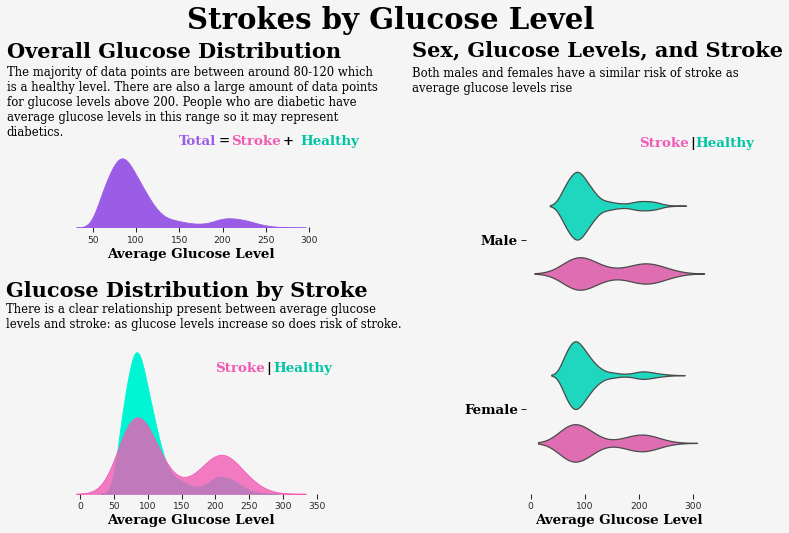

In [105]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#00f5d4','#f15bb5']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('avg_glucose_level', data=df, ax=ax1, shade=True, color='#9b5de5', alpha=1)
ax1.set_xlabel('Average Glucose Level', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax1.text(-50, 0.039, 'Overall Glucose Distribution', 
         fontfamily='serif', fontsize='25',color= 'black',fontweight='bold')
ax1.text(-50, 0.021, 'The majority of data points are between around 80-120 which\nis a healthy level. ' +\
         'There are also a large amount of data points\nfor glucose levels above 200. ' +\
         'People who are diabetic have\naverage glucose levels in this range so it may represent\ndiabetics.',
         fontfamily='serif', color= 'black', fontsize=14)
ax1.text(150, 0.019, 'Total',fontfamily='serif', fontsize='16',color= '#9b5de5',fontweight='bold')
ax1.text(195, 0.019, '=',fontfamily='serif', fontsize='16',color= 'black',fontweight='bold')
ax1.text(210, 0.019, 'Stroke',fontfamily='serif', fontsize='16',color= '#f15bb5',fontweight='bold')
ax1.text(270, 0.019, '+',fontfamily='serif', fontsize='16',color= 'black',fontweight='bold')
ax1.text(290, 0.019, 'Healthy',fontfamily='serif', fontsize='16',color= '#00c5a4',fontweight='bold')

#-------Ax 2------------------------------------------------
sns.kdeplot('avg_glucose_level', data=df[df.stroke==0], ax=ax2, shade=True, 
            color='#00f5d4', alpha=1)
sns.kdeplot('avg_glucose_level', data=df[df.stroke==1], ax=ax2, shade=True, 
            color='#f15bb5', alpha=0.8)
ax2.set_xlabel('Average Glucose Level', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax2.text(-109, 0.0225, 'Glucose Distribution by Stroke', fontfamily='serif', fontsize='25',color= 'black',fontweight='bold')
ax2.text(-109, 0.019, 'There is a clear relationship present between average glucose\nlevels and stroke: as glucose levels' +\
         ' increase so does risk of stroke.',
         fontfamily='serif', color= 'black', fontsize=14)
ax2.text(200, 0.014,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax2.text(275, 0.014,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax2.text(285, 0.014,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')

#-------Ax 3------------------------------------------------
ax3.get_yaxis().set_visible(True)
sns.violinplot(x='avg_glucose_level', y='gender', data=df[df.gender!='Other'],
               hue='stroke', ax=ax3, aspect=2, inner=None)
ax3.set_yticklabels( labels = ['Male', 'Female'],
                fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.set_ylabel('')
ax3.set_xlabel('Average Glucose Level', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.get_legend().remove()
ax3.text(-220, -1.085, 'Sex, Glucose Levels, and Stroke', fontfamily='serif', fontsize='25',color= 'black',fontweight='bold')
ax3.text(-220, -0.875, 'Both males and females have a similar risk of stroke as\naverage glucose levels rise', 
         fontfamily='serif', color= 'black', fontsize=14)
ax3.text(200,-0.55,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax3.text(295,-0.55,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.text(305,-0.55,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')
#---------------------------------------------------------------
fig.text(0.135, 0.9, 'Strokes by Glucose Level', fontfamily='serif', fontweight='bold',color= 'black', fontsize=35)
plt.show()

### Strokes by BMI
image.png

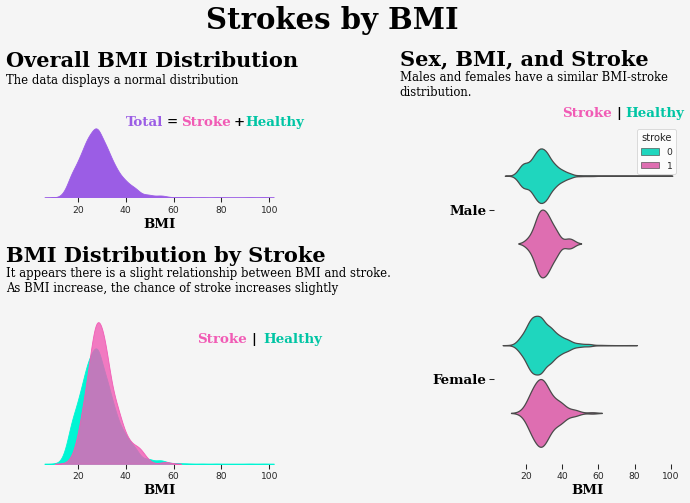

In [106]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#00f5d4','#f15bb5']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('bmi', data=df, ax=ax1, shade=True, color='#9b5de5', alpha=1)
ax1.set_xlabel('BMI', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax1.text(-10, 0.11, 'Overall BMI Distribution', 
         fontfamily='serif', fontsize='25',color='black',fontweight='bold')
ax1.text(-10, 0.095, 'The data displays a normal distribution',
         fontfamily='serif', color='black', fontsize=14)
ax1.text(40, 0.06, 'Total',fontfamily='serif', fontsize='16',color='#9b5de5',fontweight='bold')
ax1.text(57, 0.06, '=',fontfamily='serif', fontsize='16',color='black',fontweight='bold')
ax1.text(63, 0.06, 'Stroke',fontfamily='serif', fontsize='16',color='#f15bb5',fontweight='bold')
ax1.text(85, 0.06, '+',fontfamily='serif', fontsize='16',color='black',fontweight='bold')
ax1.text(90, 0.06, 'Healthy',fontfamily='serif', fontsize='16',color='#00c5a4',fontweight='bold')

#-------Ax 2------------------------------------------------
sns.kdeplot('bmi', data=df[df.stroke==0], ax=ax2, shade=True, 
            color='#00f5d4', alpha=1)
sns.kdeplot('bmi', data=df[df.stroke==1], ax=ax2, shade=True, 
            color='#f15bb5', alpha=0.8)
ax2.set_xlabel('BMI', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax2.text(-10, 0.1, 'BMI Distribution by Stroke', fontfamily='serif', fontsize='25',color='black',fontweight='bold')
ax2.text(-10, 0.085, 'It appears there is a slight relationship between BMI and stroke.\n' +\
         'As BMI increase, the chance of stroke increases slightly',
         fontfamily='serif', color='black', fontsize=14)
ax2.text(70, 0.06,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax2.text(92.5, 0.06,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax2.text(97.5, 0.06,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')

#-------Ax 3------------------------------------------------
ax3.get_yaxis().set_visible(True)
sns.violinplot(x='bmi', y='gender', data=df[df.gender!='Other'],
               hue='stroke', ax=ax3, aspect=2, inner=None)
ax3.set_yticklabels( labels = ['Male', 'Female'],
                fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.set_ylabel('')
ax3.set_xlabel('BMI', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax3.text(-50, -0.85, 'Sex, BMI, and Stroke', fontfamily='serif', fontsize='25',color='black',fontweight='bold')
ax3.text(-50, -0.67, 'Males and females have a similar BMI-stroke\ndistribution.', 
         fontfamily='serif', color='black', fontsize=14)
ax3.text(40,-0.55,'Stroke', fontfamily='serif', fontsize=16,fontweight='bold', color='#f15bb5')
ax3.text(70,-0.55,'|', fontfamily='serif', fontsize=16,fontweight='bold', color='black')
ax3.text(75,-0.55,'Healthy', fontfamily='serif', fontsize=16,fontweight='bold', color='#00c5a4')
#---------------------------------------------------------------
fig.text(0.17, 0.85, 'Strokes by BMI', fontfamily='serif', fontweight='bold',color='black', fontsize=35)
plt.show()

### Strokes by Sex

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


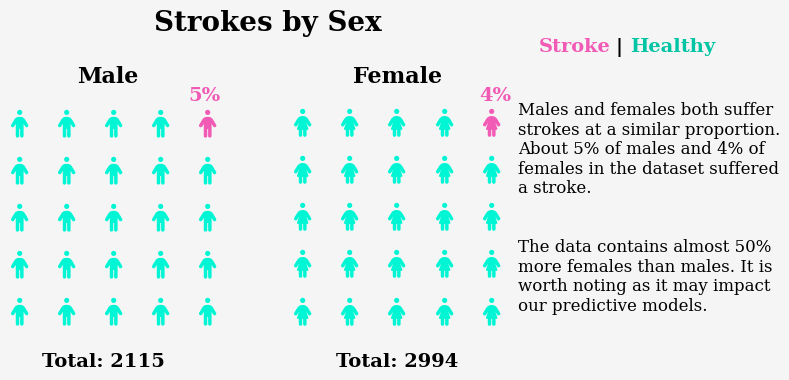

''

In [107]:
males_total = df.groupby('gender').gender.count()['Male']
per_males_healthy = df[df.stroke==0].groupby('gender').gender.count()['Male'] / males_total
per_males_stroke = df[df.stroke==1].groupby('gender').gender.count()['Male'] / males_total
males_healthy = round(per_males_healthy * 25, 0)
males_stroke = round(per_males_stroke * 25, )
females_total = df.groupby('gender').gender.count()['Female']
per_females_healthy = df[df.stroke==0].groupby('gender').gender.count()['Female'] / females_total
per_females_stroke = df[df.stroke==1].groupby('gender').gender.count()['Female'] / females_total
females_healthy = round(per_females_healthy * 25, 0)
females_stroke = round(per_females_stroke * 25, 0)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {121: #plots males with and without stroke
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [males_healthy, males_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'male',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 : #plots females with and without stroke
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[females_healthy, females_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'female',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)

fig.text(0.35, 0.75, 'Strokes by Sex', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.24, 0.675, 'Male', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.19, 0.27, 'Total: ' + str(males_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.635, 0.675, 'Female', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.61, 0.27, 'Total: ' + str(females_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.4, 0.65, str(int(per_males_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(0.815, 0.65, str(int(per_females_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(.9, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(1.01, 0.72, '|', fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(1.03, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color= '#00c5a4', fontsize=14)
fig.text(.87, 0.35, 
         'Males and females both suffer\nstrokes at a similar proportion.\n' +\
         'About 5% of males and 4% of\nfemales in the dataset suffered\na stroke.' +\
         '\n\n\nThe data contains almost 50%\nmore females than males. It is\n' +\
         'worth noting as it may impact\nour predictive models.', 
         fontfamily='serif', fontweight='normal',color= 'black', fontsize=12)

plt.show()
;

### Strokes by Hypertension

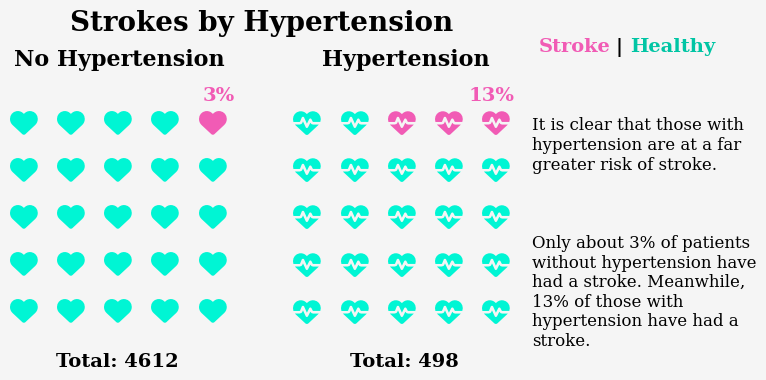

''

In [108]:
no_hypertension_total = df.groupby('hypertension').hypertension.count()[0]
per_no_hypertension_healthy = df[df.stroke==0].groupby('hypertension').hypertension.count()[0] / no_hypertension_total
per_no_hypertension_stroke = df[df.stroke==1].groupby('hypertension').hypertension.count()[0] / no_hypertension_total
no_hypertension_healthy = round(per_no_hypertension_healthy * 25, 0)
no_hypertension_stroke = round(per_no_hypertension_stroke * 25, )
hypertension_total = df.groupby('hypertension').hypertension.count()[1]
per_hypertension_healthy = df[df.stroke==0].groupby('hypertension').hypertension.count()[1] / hypertension_total
per_hypertension_stroke = df[df.stroke==1].groupby('hypertension').hypertension.count()[1] / hypertension_total
hypertension_healthy = round(per_hypertension_healthy * 25, 0)
hypertension_stroke = round(per_hypertension_stroke * 25, 0)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {121:
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [no_hypertension_healthy, no_hypertension_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heart',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 : 
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[hypertension_healthy, hypertension_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heartbeat',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)

fig.text(0.23, 0.75, 'Strokes by Hypertension', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.15, 0.7, 'No Hypertension', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.21, 0.27, 'Total: ' + str(no_hypertension_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.59, 0.7, 'Hypertension', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.63, 0.27, 'Total: ' + str(hypertension_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.42, 0.65, str(int(per_no_hypertension_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(0.8, 0.65, str(int(per_hypertension_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(.9, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(1.01, 0.72, '|', fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(1.03, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color= '#00c5a4', fontsize=14)
fig.text(.89, 0.3, 
         'It is clear that those with\nhypertension are at a far\ngreater risk of stroke.\n' +\
         '\n\n\nOnly about 3% of patients\nwithout hypertension have\nhad a stroke. Meanwhile,\n' +\
         '13% of those with\nhypertension have had a\nstroke.', 
         fontfamily='serif', fontweight='normal',color= 'black', fontsize=12)

plt.show()
;

### Strokes by Heart Disease

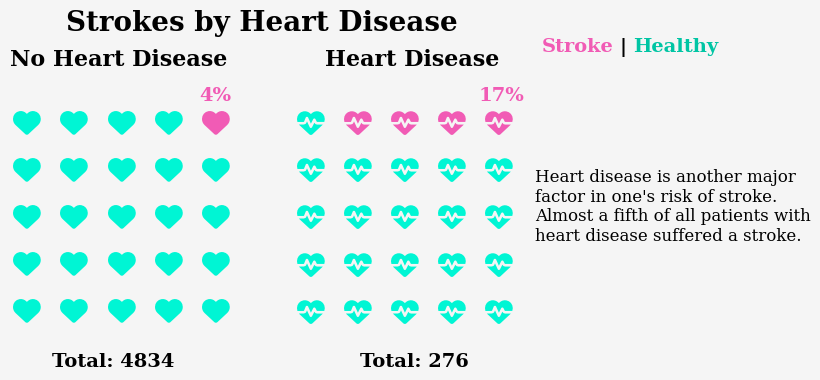

''

In [109]:
no_heart_disease_total = df.groupby('heart_disease').heart_disease.count()[0]
per_no_heart_disease_healthy = df[df.stroke==0].groupby('heart_disease').heart_disease.count()[0] / no_heart_disease_total
per_no_heart_disease_stroke = df[df.stroke==1].groupby('heart_disease').heart_disease.count()[0] / no_heart_disease_total
no_heart_disease_healthy = round(per_no_heart_disease_healthy * 25, 0)
no_heart_disease_stroke = round(per_no_heart_disease_stroke * 25, )
heart_disease_total = df.groupby('heart_disease').heart_disease.count()[1]
per_heart_disease_healthy = df[df.stroke==0].groupby('heart_disease').heart_disease.count()[1] / heart_disease_total
per_heart_disease_stroke = df[df.stroke==1].groupby('heart_disease').heart_disease.count()[1] / heart_disease_total
heart_disease_healthy = round(per_heart_disease_healthy * 25, 0)
heart_disease_stroke = round(per_heart_disease_stroke * 25, 0)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {121: 
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [no_heart_disease_healthy, no_heart_disease_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heart',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 : 
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[heart_disease_healthy, heart_disease_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heartbeat',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)

fig.text(0.22, 0.75, 'Strokes by Heart Disease', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.14, 0.7, 'No Heart Disease', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.2, 0.27, 'Total: ' + str(no_heart_disease_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.59, 0.7, 'Heart Disease', fontfamily='serif', fontweight='bold',color= 'black', fontsize=16)
fig.text(0.64, 0.27, 'Total: ' + str(heart_disease_total), fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(0.41, 0.65, str(int(per_no_heart_disease_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(0.81, 0.65, str(int(per_heart_disease_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(.9, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color= '#f15bb5', fontsize=14)
fig.text(1.01, 0.72, '|', fontfamily='serif', fontweight='bold',color= 'black', fontsize=14)
fig.text(1.03, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color= '#00c5a4', fontsize=14)
fig.text(.89, 0.45, 
         'Heart disease is another major\nfactor in one\'s risk of stroke.' +\
         '\nAlmost a fifth of all patients with\nheart disease ' +\
         'suffered a stroke.', 
         fontfamily='serif', fontweight='normal',color= 'black', fontsize=12)

plt.show()
;

### Strokes by Marrige

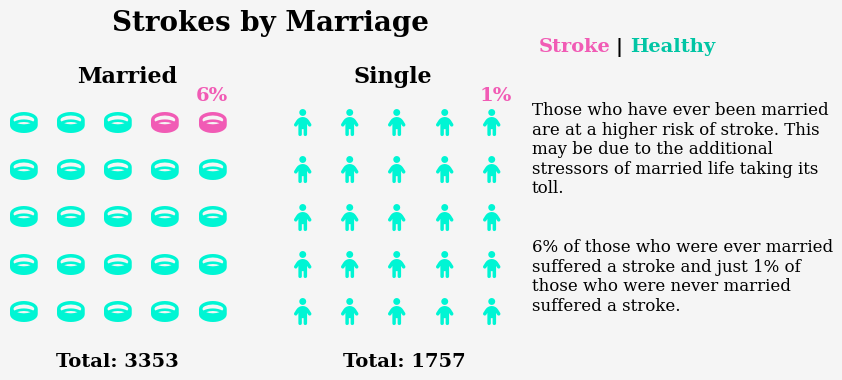

''

In [110]:
married_total = df.groupby('ever_married').ever_married.count()['Yes']
per_married_healthy = df[df.stroke==0].groupby('ever_married').ever_married.count()['Yes'] / married_total
per_married_stroke = df[df.stroke==1].groupby('ever_married').ever_married.count()['Yes'] / married_total
married_healthy = round(per_married_healthy * 25, 0)
married_stroke = round(per_married_stroke * 25, )
not_married_total = df.groupby('ever_married').ever_married.count()['No']
per_not_married_healthy = df[df.stroke==0].groupby('ever_married').ever_married.count()['No'] / not_married_total
per_not_married_stroke = df[df.stroke==1].groupby('ever_married').ever_married.count()['No'] / not_married_total
not_married_healthy = round(per_not_married_healthy * 25, 0)
not_married_stroke = round(per_not_married_stroke * 25, 0)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {121: 
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [married_healthy, married_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'ring',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 : 
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[not_married_healthy, not_married_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'child',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)

fig.text(0.29, 0.75, 'Strokes by Marriage', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.24, 0.675, 'Married', fontfamily='serif', fontweight='bold',color='black', fontsize=16)
fig.text(0.21, 0.27, 'Total: ' + str(married_total), fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(0.635, 0.675, 'Single', fontfamily='serif', fontweight='bold',color='black', fontsize=16)
fig.text(0.62, 0.27, 'Total: ' + str(not_married_total), fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(0.41, 0.65, str(int(per_married_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.815, 0.65, str(int(per_not_married_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(.9, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(1.01, 0.72, '|', fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(1.03, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color='#00c5a4', fontsize=14)
fig.text(.89, 0.35, 
         'Those who have ever been married\nare at a higher risk of stroke. This\nmay ' +\
         'be due to the additional\nstressors of married life taking its\ntoll.' +\
         '\n\n\n6% of those who were ever married\nsuffered a stroke and just 1% of\nthose ' +\
         'who were never married\nsuffered a stroke.', 
         fontfamily='serif', fontweight='normal',color='black', fontsize=12)

plt.show()
;

That was expected, wasn't it 👀


![](https://media.giphy.com/media/AIGA5rzzs4ygo/giphy.gif)

### Strokes by Work Type

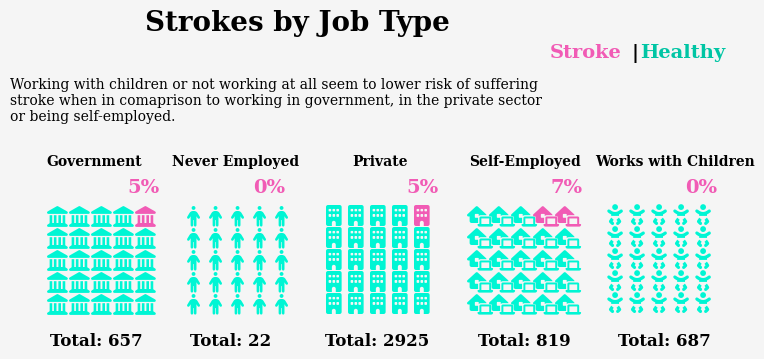

''

In [111]:
govt_job_total = df.groupby('work_type').work_type.count()['Govt_job']
per_govt_job_healthy = df[df.stroke==0].groupby('work_type').work_type.count()['Govt_job'] / govt_job_total
per_govt_job_stroke = df[df.stroke==1].groupby('work_type').work_type.count()['Govt_job'] / govt_job_total
govt_job_healthy = round(per_govt_job_healthy * 25, 0)
govt_job_stroke = round(per_govt_job_stroke * 25, 0)
#---------------------------------------------------------------------
never_worked_total = df.groupby('work_type').work_type.count()['Never_worked']
per_never_worked_healthy = df[df.stroke==0].groupby('work_type').work_type.count()['Never_worked'] / never_worked_total
per_never_worked_stroke =  0 #no instances of never worked + stroke
never_worked_healthy = round(per_never_worked_healthy * 25, 0)
never_worked_stroke = round(per_never_worked_stroke * 25, 0)
#-----------------------------------------------------------------------
private_total = df.groupby('work_type').work_type.count()['Private']
per_private_healthy = df[df.stroke==0].groupby('work_type').work_type.count()['Private'] / private_total
per_private_stroke = df[df.stroke==1].groupby('work_type').work_type.count()['Private'] / private_total
private_healthy = round(per_private_healthy * 25, 0)
private_stroke = round(per_private_stroke * 25, 0)
#--------------------------------------------------------------------
self_employed_total = df.groupby('work_type').work_type.count()['Self-employed']
per_self_employed_healthy = df[df.stroke==0].groupby('work_type').work_type.count()['Self-employed'] / self_employed_total
per_self_employed_stroke = df[df.stroke==1].groupby('work_type').work_type.count()['Self-employed'] / self_employed_total
self_employed_healthy = round(per_self_employed_healthy * 25, 0)
self_employed_stroke = round(per_self_employed_stroke * 25, 0)
#--------------------------------------------------------------------
children_total = df.groupby('work_type').work_type.count()['children']
per_children_healthy = df[df.stroke==0].groupby('work_type').work_type.count()['children'] / children_total
per_children_stroke = df[df.stroke==1].groupby('work_type').work_type.count()['children'] / children_total
children_healthy = round(per_children_healthy * 25, 0)
children_stroke = round(per_children_stroke * 25, 0)
#--------------------------------------------------------------------



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (9,9),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {
                     151:
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [govt_job_healthy, govt_job_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.005,
                              'interval_ratio_x': 0.005,
                              'icons' : 'landmark',
                              'icon_legend': False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                        152 :
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[never_worked_healthy, never_worked_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.005,
                              'interval_ratio_x': 0.005,
                              'icons' : 'male',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           },
                          
                        153 :
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[private_healthy, private_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.005,
                              'interval_ratio_x': 0.005,
                              'icons' : 'building',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           },
                     
                        154 :
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[self_employed_healthy, self_employed_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.005,
                              'interval_ratio_x': 0.005,
                              'icons' : 'laptop-house',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           },
                     
                        155 :
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[children_healthy, children_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.005,
                              'interval_ratio_x': 0.005,
                              'icons' : 'baby',
                              'icon_legend' :False,
                              'icon_size':15,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                     
                         },
                   
)

fig.text(0.25, 0.75, 'Strokes by Job Type', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.14, 0.6, 'Government', fontfamily='serif', fontweight='bold',color='black', fontsize=10)
fig.text(0.145, 0.4, 'Total: ' + str(govt_job_total), fontfamily='serif', fontweight='bold',color='black', fontsize=12)
fig.text(0.28, 0.6, 'Never Employed', fontfamily='serif', fontweight='bold',color='black', fontsize=10)
fig.text(0.3, 0.4, 'Total: ' + str(never_worked_total), fontfamily='serif', fontweight='bold',color='black', fontsize=12)
fig.text(0.48, 0.6, 'Private', fontfamily='serif', fontweight='bold',color='black', fontsize=10)
fig.text(0.45, 0.4, 'Total: ' + str(private_total), fontfamily='serif', fontweight='bold',color='black', fontsize=12)
fig.text(0.61, 0.6, 'Self-Employed', fontfamily='serif', fontweight='bold',color='black', fontsize=10)
fig.text(0.62, 0.4, 'Total: ' + str(self_employed_total), fontfamily='serif', fontweight='bold',color='black', fontsize=12)
fig.text(0.75, 0.6, 'Works with Children', fontfamily='serif', fontweight='bold',color='black', fontsize=10)
fig.text(0.775, 0.4, 'Total: ' + str(children_total), fontfamily='serif', fontweight='bold',color='black', fontsize=12)
fig.text(0.23, 0.57, str(int(per_govt_job_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.37, 0.57, str(int(per_never_worked_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.54, 0.57, str(int(per_private_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.7, 0.57, str(int(per_self_employed_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.85, 0.57, str(int(per_children_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(.7, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(.79, 0.72, '|', fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(.8, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color='#00c5a4', fontsize=14)
fig.text(.1, 0.65, 
         'Working with children or not working at all seem to lower risk of suffering\nstroke when in comaprison ' +\
         'to working in government, in the private sector\nor being self-employed.', 
         fontfamily='serif', fontweight='normal',color='black', fontsize=10)

plt.show()
;

### Strokes by Residence Type

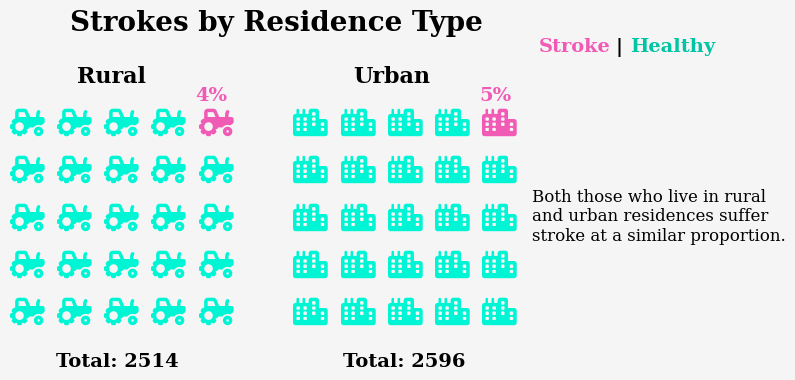

''

In [112]:
rural_total = df.groupby('Residence_type').Residence_type.count()['Rural']
per_rural_healthy = df[df.stroke==0].groupby('Residence_type').Residence_type.count()['Rural'] / rural_total
per_rural_stroke = df[df.stroke==1].groupby('Residence_type').Residence_type.count()['Rural'] / rural_total
rural_healthy = round(per_rural_healthy * 25, 0)
rural_stroke = round(per_rural_stroke * 25, )
urban_total = df.groupby('Residence_type').Residence_type.count()['Urban']
per_urban_healthy = df[df.stroke==0].groupby('Residence_type').Residence_type.count()['Urban'] / urban_total
per_urban_stroke = df[df.stroke==1].groupby('Residence_type').Residence_type.count()['Urban'] / urban_total
urban_healthy = round(per_urban_healthy * 25, 0)
urban_stroke = round(per_urban_stroke * 25, 0)



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f5f5f5',dpi = 100,
                 
                 plots = {121: 
                          {     
                           'rows':5,
                           'columns': 5,
                           'values' : [rural_healthy, rural_stroke],
                            'colors' : ['#00f5d4','#f15bb5'],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'tractor',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 : 
                          { 
                            'rows': 5,
                            'columns':5,
                            'values':[urban_healthy, urban_stroke],         
                              'colors' : ['#00f5d4','#f15bb5'],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'city',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },        
)

fig.text(0.23, 0.75, 'Strokes by Residence Type', fontfamily='serif', fontsize=20, fontweight='bold', color='black')
fig.text(0.24, 0.675, 'Rural', fontfamily='serif', fontweight='bold',color='black', fontsize=16)
fig.text(0.21, 0.27, 'Total: ' + str(rural_total), fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(0.635, 0.675, 'Urban', fontfamily='serif', fontweight='bold',color='black', fontsize=16)
fig.text(0.62, 0.27, 'Total: ' + str(urban_total), fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(0.41, 0.65, str(int(per_rural_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(0.815, 0.65, str(int(per_urban_stroke * 100)) + '%', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(.9, 0.72, 'Stroke', fontfamily='serif', fontweight='bold',color='#f15bb5', fontsize=14)
fig.text(1.01, 0.72, '|', fontfamily='serif', fontweight='bold',color='black', fontsize=14)
fig.text(1.03, 0.72, 'Healthy', fontfamily='serif', fontweight='bold',color='#00c5a4', fontsize=14)
fig.text(.89, 0.45, 
         'Both those who live in rural\nand urban residences suffer\nstroke at a similar proportion.', 
         fontfamily='serif', fontweight='normal',color='black', fontsize=12)

plt.show()
;

### Various Factors Affecting Strokes

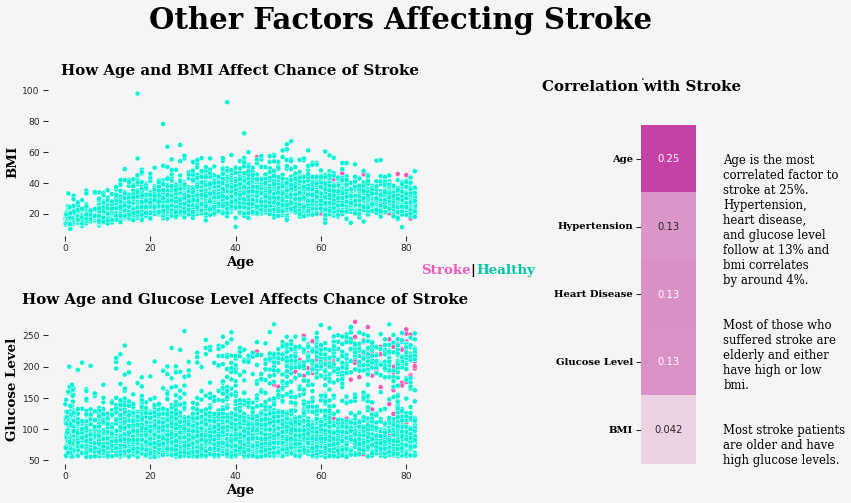

In [113]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#00f5d4','#f15bb5']))

ax1 = fig.add_subplot(gs[2:6, 0:6])
ax2 = fig.add_subplot(gs[8:, 0:6])
ax3 = fig.add_subplot(gs[3:, 9:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#-------Ax 1------------------------------------------------
sns.scatterplot(x='age', y='bmi', hue='stroke', data=df, ax=ax1)
ax1.get_legend().remove()
ax1.set_xlabel('Age', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax1.set_ylabel('BMI', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax1.text(-1, 110, 'How Age and BMI Affect Chance of Stroke', 
         fontfamily='serif', fontsize=18, fontweight='bold', color='black')

#-------Ax 2------------------------------------------------
sns.scatterplot(x='age', y='avg_glucose_level', hue='stroke', data=df, ax=ax2)
ax2.get_legend().remove()
ax2.set_xlabel('Age', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax2.set_ylabel('Glucose Level', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax2.text(-10, 300, 'How Age and Glucose Level Affects Chance of Stroke', 
         fontfamily='serif', fontsize=18, fontweight='bold', color='black')

#-------Ax 3------------------------------------------------
cmap = sns.diverging_palette(10, 325, as_cmap=True)
sns.heatmap(pd.DataFrame(df.corr().iloc[:-1, -1]), cmap=cmap, annot=True, center=0, cbar=False)
ax3.set_xticks([-1])
ax3.set_yticklabels(labels = ['Age', 'Hypertension', 'Heart Disease', 'Glucose Level', 'BMI'],
                fontfamily='serif', fontsize=12,fontweight='bold', color='black')
ax3.text(-1.8, -0.5, 'Correlation with Stroke', fontfamily='serif', fontsize=18, fontweight='bold', color='black')
ax3.text(0, -0.67, '.', 
         fontfamily='serif', color= 'black', fontsize=14)
ax3.text(-4,2.2,'Stroke', fontfamily='serif', fontsize=16, fontweight='bold', color='#f15bb5')
ax3.text(-3.1,2.2,'|', fontfamily='serif', fontsize=16, fontweight='bold', color='black')
ax3.text(-3, 2.2,'Healthy', fontfamily='serif', fontsize=16, fontweight='bold', color='#00c5a4')
ax3.text(1.5, 5, 'Age is the most\ncorrelated factor to\nstroke at 25%.\nHypertension,\nheart disease,\n' +\
         'and glucose level\nfollow at 13% and\nbmi correlates\nby around 4%.\n\n\n' +\
         'Most of those who\nsuffered stroke are\nelderly and either\nhave high or low\nbmi.\n\n\n' +\
         'Most stroke patients\nare older and have\nhigh glucose levels.',
         fontfamily='serif', color= 'black', fontsize=14)
#---------------------------------------------------------------
fig.text(0.12, 0.85, 'Other Factors Affecting Stroke', fontfamily='serif', fontweight='bold',color= 'black', fontsize=35)
plt.show()

## Data Preprocessing

Now that we understood the data, the data can be processed to be fed to the neural network. First catagoric variables will be one hot encoded. After this we will take care of the null values for bmi. The KNN imputer will be used to fill in the missing values , basing the new values off of similar patients. After that, the numeric variables will be scaled. Next, SMOTE will be used to increase the number of data points that are of the positive class (stroke). Finally, the data set will be split into train, validation and test datasets.

In [114]:
#removes labels from dataset
X, y = df.drop('stroke', axis=1).values, df['stroke'].values

#Encodes catagoric variables
cat_ix = [0, 4, 5, 6, 9] #index of catagoric variables
cat_ct = ColumnTransformer([
    ('cat_vars', OneHotEncoder(), cat_ix)
], remainder='passthrough')
X_encoded = cat_ct.fit_transform(X)

#Impute missing values
#create KNN imputer object
knn_imp = KNNImputer(n_neighbors=5)
X_imputed = knn_imp.fit_transform(X_encoded)

#Scale Numeric Variables
num_ix = [16, 19, 20] #index of numeric variables
num_ct = ColumnTransformer([
    ('num_vars', StandardScaler(), num_ix)
], remainder='passthrough')
X_scaled = num_ct.fit_transform(X_imputed)

#displays scaled data
print('Example of Processed Data:')
print(X_scaled[0])

Example of Processed Data:
[1.05143428 2.70637544 0.98721932 0.         1.         0.
 0.         1.         0.         0.         1.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         1.        ]


In [115]:
#Splits the data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)

#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 3577
Samples in Validation Set: 766
Samples in Test Set: 767


In [116]:
#SMOTE for class balancing
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

#Displays perccent of each class
print('Initial Dataset')
print('Percent "stroke":', y_train.sum()/len(y_train))
print('Balanced Dataset')
print('Percent "stroke":', y_bal.sum()/len(y_bal))

Initial Dataset
Percent "stroke": 0.048364551299972046
Balanced Dataset
Percent "stroke": 0.5


<h5>Now the data is clean and the dataset is perfectly balanced. Time to work on the neural network!</h5>

## Model



### NN Architecture

In [121]:
#creates a dense network with 1 skip step
inputs = keras.Input(shape=(21,))
a = layers.Dense(600, activation='relu')(inputs)
x = layers.Dropout(0.6)(a)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.concatenate([a, x])

x = layers.Dense(600, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)

output = layers.Dense(1, activation='sigmoid')(x)

nn = keras.Model(inputs, output, name="stroke_predictor")
nn.summary()

Model: "stroke_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 600)          13200       ['input_6[0][0]']                
                                                                                                  
 dropout_30 (Dropout)           (None, 600)          0           ['dense_35[0][0]']               
                                                                                                  
 dense_36 (Dense)               (None, 128)          76928       ['dropout_30[0][0]']             
                                                                                   

### Training

In [122]:
#compiles the model with Adam optimizer
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

#Trains the neural network
history = nn.fit(X_bal, y_bal, epochs=1000, callbacks=[early_stopper], validation_data=(X_val, y_val))

Epoch 1/1000
213/213 [==============================] - 4s 9ms/step - loss: 0.9076 - accuracy: 0.5727 - val_loss: 0.6774 - val_accuracy: 0.5783
Epoch 2/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.7257 - accuracy: 0.6542 - val_loss: 0.5930 - val_accuracy: 0.6567
Epoch 3/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.6623 - accuracy: 0.6879 - val_loss: 0.6175 - val_accuracy: 0.6397
Epoch 4/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.6538 - accuracy: 0.6979 - val_loss: 0.5807 - val_accuracy: 0.6645
Epoch 5/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.6029 - accuracy: 0.7214 - val_loss: 0.5930 - val_accuracy: 0.6488
Epoch 6/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.5838 - accuracy: 0.7268 - val_loss: 0.5759 - val_accuracy: 0.6540
Epoch 7/1000
213/213 [==============================] - 2s 8ms/step - loss: 0.5547 - accuracy: 0.7413 - val_loss: 0.5658 - val_accuracy:

#### Metrics

In [123]:
# Loss Graph
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Learning Curve: Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Training Loss', 'Validation Loss'])

# Accuracy Graph
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Learning Curve: Accuracy over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
;

''

### Evaluation

In [124]:
#Display the metrics of the neural network on the test set
test_preds = nn.predict(X_test)
threshold = 0.25
test_preds = [1. if i > threshold else 0. for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
print('Test Set Metrics')
print('Model Accuracy:', test_acc)
print('Model Recall:', test_rec)
print('Model Precision:', test_pre)

24/24 [==============================] - 0s 2ms/step
Test Set Metrics
Model Accuracy: 0.8865710560625815
Model Recall: 0.28205128205128205
Model Precision: 0.15714285714285714


<h5>With a threshold of 0.25, a majority of at risk patients were identified. This decreased the accuracy to around 88% and will lead to around 12% of patients being falsley identified as at risk. These are acceptable numbers for the this problem.</h5>

## Conclusion

* **Age is a major risk factor for stroke**. As we get older we are more at risk to suffer a stroke.
* Males and females both suffer stroke at a similar rate. However, females have been shown to suffer strokes at younger ages than males.
* **Heart problems like hypertension and heart disease greatly increase the risk of stroke**.
* **People who have been married are at a higher risk of stroke**. This may be due to higher levels of stress that occur during married life.
* Working with children or not working at all seems to lower the risk of stroke. This may be because working with children or not working causes less stress.
* **The predictive model will identify at most (88%)** at risk patients. This does come at the cost of a somewhat lower accuracy (88%), but in this situation it is better to have a higher false positive rate than a false negative rate.